In [62]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader
import io
from keras_preprocessing.text import tokenizer_from_json
from gensim.models import Word2Vec

from sklearn.manifold import TSNE



In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [63]:
embedding_algorithms = ["w2v", "ft", "bert", "codebert"]
embedding_algorithm = embedding_algorithms[0]
train_embs = True

In [64]:
representations = ["bow", "sequences"]
representation_form = representations[1]

In [65]:
# binary or multi-class
multi = True

In [66]:
if representation_form == "bow":
    data = pd.read_csv('bow_data.csv') # bow
else:
    data = pd.read_csv('sequences_data.csv') # sequences of tokens

In [67]:
data.head()

,Vulnerability,Category,Length
0,"f""str$id""""str$id""""str$id"" ...",sql_injection,9
1,client.listentcp() proxy = proxy(proxy_...,xsrf,8
2,"from django.http import httpresponse, httpresp...",open_redirect,9
3,"def write_preset(conn, queryin, descriptin):\t...",sql_injection,175
4,update_query = self.up...,sql_injection,14


In [68]:
if representation_form == "bow":
    bow_size = 237 # number of columns that stand as features|

In [69]:
np.max(data["Length"])

392

In [70]:
if representation_form == "sequences":
    word_counts = data["Vulnerability"].apply(lambda x: len(x.split()))
    max_length = word_counts.max()
    print("Maximum number of words:", max_length)


Maximum number of words: 392


In [71]:
label_frequencies = data['Category'].value_counts()
print("Label Frequencies:\n", label_frequencies)
print("Total samples ", len(data))

Label Frequencies:
 sql_injection            1424
xsrf                      976
command_injection         721
path_disclosure           481
open_redirect             442
remote_code_execution     334
xss                       145
Name: Category, dtype: int64
Total samples  4523


In [72]:
if multi == True:
    n_categories = len(label_frequencies) # 7
    n_categories

In [73]:
if multi == True:
    
    # Convert categories to numerical indexes
    category_numerical_indexes, unique_categories = data["Category"].factorize()

    # Create a dictionary mapping each category to its numerical index
    category_to_index = {category: index for index, category in enumerate(unique_categories)}

    # Update the categories in the DataFrame with their numerical indexes
    data["Category_Index"] = data["Category"].map(category_to_index)

In [74]:
if representation_form == "sequences":

    # Download the Punkt tokenizer models if not already downloaded
    nltk.download('punkt')

    tokenized_list = [word_tokenize(sentence) for sentence in data["Vulnerability"].tolist()]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iliaskaloup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [77]:
if embedding_algorithm == "codebert" and representation_form == "sequences": 
    model_variation = "microsoft/codebert-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True)
    codebert = TFAutoModel.from_pretrained(model_variation)
    
    codebert_embeddings = codebert.get_input_embeddings()
    embedding_matrix = codebert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

In [78]:
def padSequences(sequences, max_len):
    lines_pad = []
    for sequence in sequences:
        seq = sequence['input_ids'].numpy()[0]
        if len(seq) < max_len:
            for i in range(len(seq), max_len):
                seq = np.append(seq, 0)
        lines_pad.append(seq)
    return lines_pad


In [79]:
if embedding_algorithm == "codebert" and representation_form == "sequences": 

    sentences = data["Vulnerability"].tolist()
    sequences = [tokenizer(sente, return_tensors="tf", truncation=True, add_special_tokens=False) for sente in sentences]
    
    lines_pad = padSequences(sequences, 512)
    lines_pad = [arr.tolist() for arr in lines_pad]
    lines_pad = np.array(lines_pad)

In [102]:
def vectorize(words, emb_vectors, dim):
    words_vecs = [emb_vectors[word] for word in words if word in emb_vectors]
    if len(words_vecs) == 0:
        return np.zeros(dim)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

T-SNE Plots

BoW

D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


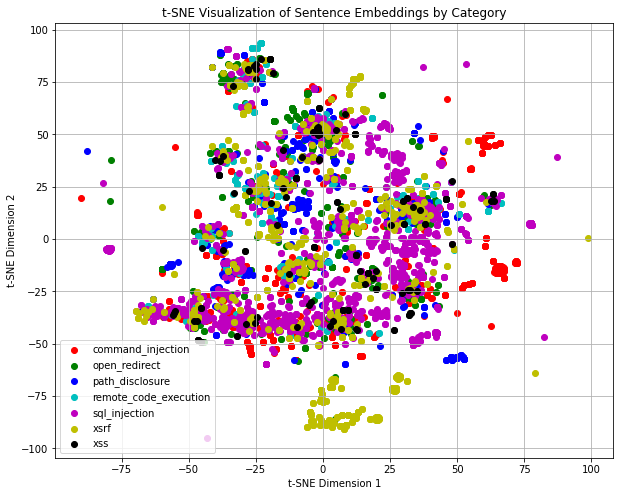

In [24]:
tsne = TSNE(n_components=2, random_state=seed)

if representation_form == "bow":
    embeddings_tsne = tsne.fit_transform(data.iloc[:, 0:bow_size])

    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of Sentence Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [104]:
embedding_algorithms = ["w2v", "ft", "bert", "codebert"]
embedding_algorithm = embedding_algorithms[2]

In [82]:
if embedding_algorithm == "w2v" and representation_form == "sequences" and train_embs == False:
    emb_vectors = gensim.downloader.load('word2vec-google-news-300')
elif embedding_algorithm == "ft" and representation_form == "sequences" and train_embs == False:
    emb_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')
elif embedding_algorithm == "w2v" and representation_form == "sequences" and train_embs == True:
    emb_vectors = Word2Vec.load('w2v_model.model')
elif embedding_algorithm == "ft" and representation_form == "sequences" and train_embs == True:
    emb_vectors = FastText.load('fast-text_model.model')

Word2Vec

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


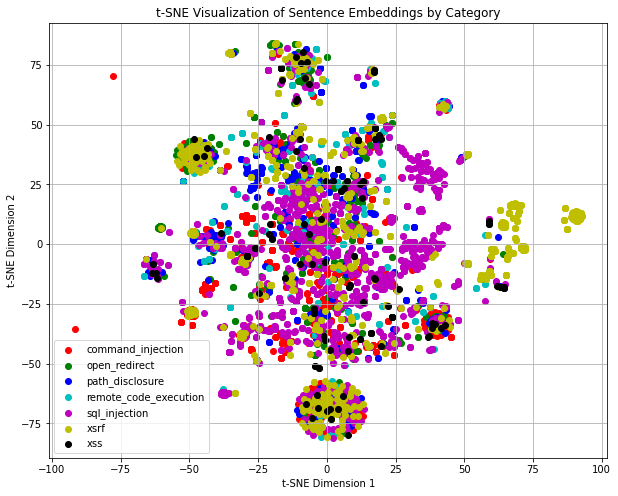

In [39]:
tsne = TSNE(n_components=2, random_state=seed)

if representation_form == "sequences" and embedding_algorithm == "w2v" and train_embs == False:
    embs = np.array([vectorize(sentence, emb_vectors, 300) for sentence in np.array(tokenized_list)])
    embeddings_tsne = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of Sentence Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Fast Text

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


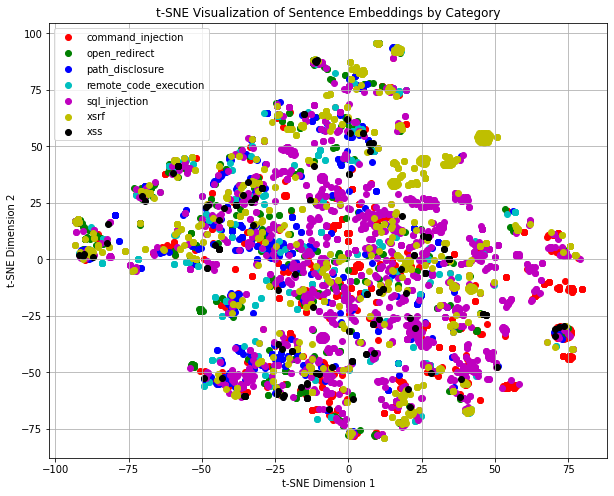

In [43]:
tsne = TSNE(n_components=2, random_state=seed)

if representation_form == "sequences" and embedding_algorithm == "ft" and train_embs == False:
    embs = np.array([vectorize(sentence, emb_vectors, 300) for sentence in np.array(tokenized_list)])
    embeddings_tsne = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of Sentence Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Python Word2Vec

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


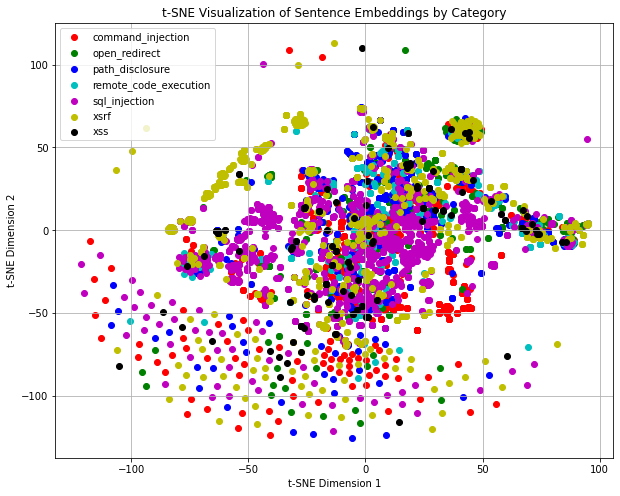

In [103]:
tsne = TSNE(n_components=2, random_state=seed)

if representation_form == "sequences" and embedding_algorithm == "w2v" and train_embs == True:
    embs = np.array([vectorize(sentence, emb_vectors.wv, 100) for sentence in np.array(tokenized_list)])
    embeddings_tsne = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of Sentence Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Python Fast Text

In [ ]:
tsne = TSNE(n_components=2, random_state=seed)

if representation_form == "sequences" and embedding_algorithm == "ft" and train_embs == True:
    embs = np.array([vectorize(sentence, emb_vectors, 100) for sentence in np.array(tokenized_list)])
    embeddings_tsne = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of Sentence Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

BERT

In [ ]:
if representation_form == "sequences" and embedding_algorithm == "bert":

    model_variation = "bert-base-uncased"  
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    bert = TFAutoModel.from_pretrained(model_variation)

    # Tokenize sentences and obtain BERT embeddings
    sentences = data["Vulnerability"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, max_length=512, padding="max_length", add_special_tokens=False, return_tensors="tf") for sente in sentences]
    embeddings = [bert(sequence)[0][:, 0, :].numpy() for sequence in sequences]  # Extract embeddings from BERT's output

    # Apply t-SNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, random_state=seed)

    embeddings_tsne = tsne.fit_transform(np.array(embeddings))

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of BERT Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


CodeBERT

In [ ]:
if representation_form == "sequences" and embedding_algorithm == "codebert":

    model_variation = "microsoft/codebert-base"  
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    codebert = TFAutoModel.from_pretrained(model_variation)

    # Tokenize sentences and obtain BERT embeddings
    sentences = data["Vulnerability"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, max_length=512, padding="max_length", add_special_tokens=False, return_tensors="tf") for sente in sentences]
    embeddings = [codebert(sequence)[0][:, 0, :].numpy() for sequence in sequences]  # Extract embeddings from BERT's output

    # Apply t-SNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, random_state=seed)

    embeddings_tsne = tsne.fit_transform(np.array(embeddings))

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    class_labels = np.unique(data["Category"])
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, class_label in enumerate(class_labels):
        indices = np.where(data["Category"] == class_label)
        plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

    plt.title('t-SNE Visualization of BERT Embeddings by Category')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()
